<a href="https://colab.research.google.com/github/tylerlum/Tray_Image_Classifier_A/blob/master/Tray_Image_Classifier_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
#from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict

%matplotlib inline
np.random.seed(1)

import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
#from kt_utils import *

from keras.losses import binary_crossentropy

import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
#from resnets_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)
from keras import optimizers
from keras import losses
from keras import metrics
import random
import copy

In [0]:
##################################### Small Helper Functions #####################################
def download_files():
  """
  Use google_drive_downloader to download HiRes and LoRes data
  """
  !pip install googledrivedownloader
  from google_drive_downloader import GoogleDriveDownloader as gdd

  gdd.download_file_from_google_drive(file_id='1smbsz8AJ-VGhKbtr7NTvAVzTI3auI_C4',
                                      dest_path='/content/tray-data/HiRes.7z')
  gdd.download_file_from_google_drive(file_id='1wZ-AHv4yx_lXGeaqKzbTNuap6mpESyEq',
                                      dest_path='/content/tray-data/LoRes.7z')

  # Extract.7z file
  %cd /content/tray-data
  if not 'data_LoRes' in [directory for directory in os.listdir('/content/tray-data/')]:
    !7z x /content/tray-data/LoRes.7z 
  if not 'data_HiRes' in [directory for directory in os.listdir('/content/tray-data/')]:
    !7z x /content/tray-data/HiRes.7z 
  
def get_one_hot_encoding(class_names):
  """
  Create a dictionary that maps class names to integers from 0 upwards. 
  Requires non-empty list
  """
  ordered_class_names = copy.copy(class_names)
  ordered_class_names.sort()
  one_hot_encoding = {}
  i = 0
  for class_name in ordered_class_names:
    one_hot_encoding[class_name] = i
    i = i + 1
  return one_hot_encoding

def get_distinct_random_ints(num_ints, low, high):
  """
  Returns list of length num_ints
  Each value is a number n such that low <= n <= high
  Each value is distinct
  If num_ints > (high-low+1), 
  then this returns a list of all integers from low to high inclusive in a random order
  """
  retVal = []
  # Handle edge case
  if num_ints > (high-low+1):
    num_ints = high-low+1
  
  # Insert num_ints distinct integers in random order
  for i in range(0, num_ints):
    rand_int = random.randint(low, high)
    while rand_int in retVal:
      rand_int = random.randint(low, high)
    retVal.append(rand_int)
  return retVal

def one_hot_encode(class_name, num_classes, one_hot_encoding):
  retVal = np.zeros((num_classes, 1))
  retVal[one_hot_encoding[class_name]] = 1
  return retVal

##################################### Medium Helper Functions #####################################
def load_full_dataset(path_to_imgs):
  """
  Creates a dictionary that maps class names to numpy arrays representing images
  Requires a full path to the images
  """
  full_dataset = {}
  i = 0
  for directory in os.listdir(path_to_imgs):
    x_data = []
    directory_path = path_to_imgs + '/' + directory
    for png in os.listdir(directory_path):
      # Get image and convert to numpy array
      png_path = directory_path + '/' + png
      im = cv2.imread(png_path)
      im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
      x_data.append(im)
      
    ## Add key value pair to full_dataset
    full_dataset[str(directory)] = x_data
    
  return full_dataset

def get_dataset(full_dataset, desired_classes, pics_per_class):
  """
  full_dataset = dictionary from classes to image data
  desired_classes = list of desired classes
  pics_per_class = integer number of pictures for each class
  S"""
  # One hot encoding setup
  one_hot_encoding = get_one_hot_encoding(desired_classes)
  
  # Initialize return values
  X = None
  Y = None
  
  num_classes = len(desired_classes)
  
  for class_name in desired_classes:
    
    indices = get_distinct_random_ints(pics_per_class, 0, len(full_dataset[class_name]) - 1)

    # Add images from this class
    for index in indices:
      
      im = full_dataset[class_name][index]
      # Add to training set
      # Initialize array
      if X is None:
        X = np.array([im])
        label = one_hot_encode(class_name, num_classes, one_hot_encoding)
        Y = np.array([label])
      # Append to array
      else:
        X = np.append(X, [im], axis=0)
        label = one_hot_encode(class_name, num_classes, one_hot_encoding)
        Y = np.append(Y, [label], axis=0)

  Y = Y[:, :, 0].T
  return X, Y
           
def load_train_and_test_dataset(path_to_imgs, desired_classes=None, pics_per_class=70):
  # Handle default case
  if desired_classes is None:
    desired_classes = os.listdir(path_to_imgs)
  
  # Load full dataset
  full_dataset = load_full_dataset(path_to_imgs)
  
  # Get training and testing data from full_dataset
  X_train, Y_train = get_dataset(full_dataset, desired_classes=desired_classes, pics_per_class=pics_per_class)
  X_test, Y_test = get_dataset(full_dataset, desired_classes=desired_classes, pics_per_class=pics_per_class // 2)  # Note may have some matching with training data
  return X_train, Y_train, X_test, Y_test

In [0]:
download_files()

/content/tray-data


In [0]:
# Check number of pictures in dataset
num_pics = 0
total_pics_per_class = {}
for directory in os.listdir('/content/tray-data/data_LoRes/single'):
  pictures = [png for png in os.listdir('/content/tray-data/data_LoRes/single' + '/' + directory)]
  num_pics = num_pics + len(pictures)
  total_pics_per_class[directory] = len(pictures)
  
print(num_pics)
print(total_pics_per_class)

3847
{'L09': 200, 'L01': 99, 'L04': 196, 'L07': 200, 'L13': 191, 'L03': 197, 'L06': 200, 'L10': 200, 'L12': 200, 'L15': 191, 'S1': 99, 'L16': 200, 'S4': 99, 'S3': 99, 'S5': 99, 'L18': 187, 'S2': 99, 'L11': 200, 'L14': 195, 'L08': 200, 'L05': 200, 'L02': 99, 'L17': 197}


In [0]:
# MAIN CODE: Create dataset
path_to_imgs = '/content/tray-data/data_LoRes/single'
desired_classes = ['L01','L02','L03','L04','L05', 'L06']
#desired_classes = ['L09','L04']
#desired_classes = os.listdir(path_to_imgs)
pics_per_class = 70

X_train, Y_train, X_test, Y_test = load_train_and_test_dataset(path_to_imgs, desired_classes=desired_classes, pics_per_class=pics_per_class)

## Slight difference in preferred orientation
Y_train = Y_train.T
Y_test = Y_test.T

In [0]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(420, 64, 64, 3)
(420, 6)
(210, 64, 64, 3)
(210, 6)


In [0]:
# For debugging
one_hot_encoding = get_one_hot_encoding(desired_classes)
print(one_hot_encoding)

{'L01': 0, 'L02': 1, 'L03': 2, 'L04': 3, 'L05': 4, 'L06': 5}


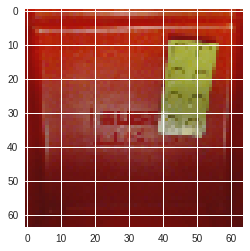

In [0]:
full_dataset = load_full_dataset(path_to_imgs)
plt.imshow(full_dataset['L09'][3])

[0. 1. 0. 0. 0. 0.]


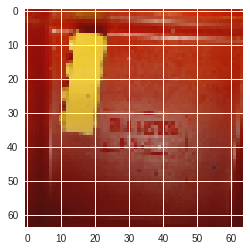

In [0]:
index = 120
plt.imshow(X_train[index])
print(Y_train[index])

[1. 0. 0. 0. 0. 0.]


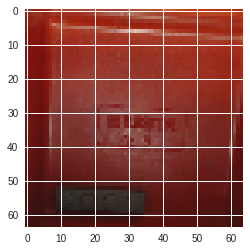

In [0]:
index = 14
plt.imshow(X_test[index])
print(Y_test[index])

In [0]:
# Standardize data to have feature values between 0 and 1.
train_x = X_train/255.
test_x = X_test/255.

train_y = Y_train
test_y = Y_test

In [0]:
print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))
print ("train_y's shape: " + str(train_y.shape))
print ("test_y's shape: " + str(test_y.shape))

train_x's shape: (420, 64, 64, 3)
test_x's shape: (210, 64, 64, 3)
train_y's shape: (420, 6)
test_y's shape: (210, 6)


In [0]:
# GRADED FUNCTION: identity_block

def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1), padding='same', name=conv_name_base+'2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding='same', name=conv_name_base+'2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [0]:
# GRADED FUNCTION: convolutional_block

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides=(1,1), padding='same', name=conv_name_base+'2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1,1), strides=(1,1), padding='valid', name=conv_name_base+'2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1,1), strides=(s,s), padding='valid', name=conv_name_base+'1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base+'1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [0]:
# GRADED FUNCTION: ResNet50

def ResNet50(input_shape = (64, 64, 3), classes = 23):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    print(2)
    print(X.shape)
    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f=3, filters=[128,128,512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128,128,512], stage=3, block='b')
    X = identity_block(X, 3, [128,128,512], stage=3, block='c')
    X = identity_block(X, 3, [128,128,512], stage=3, block='d')
    print(3)
    print(X.shape)
    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f=3, filters=[256,256,1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256,256,1024], stage=4, block='b')
    X = identity_block(X, 3, [256,256,1024], stage=4, block='c')
    X = identity_block(X, 3, [256,256,1024], stage=4, block='d')
    X = identity_block(X, 3, [256,256,1024], stage=4, block='e')
    X = identity_block(X, 3, [256,256,1024], stage=4, block='f')
    print(4)
    print(X.shape)
    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f=3, filters=[512,512,2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512,512,2048], stage=5, block='b')
    X = identity_block(X, 3, [512,512,2048], stage=5, block='c')
    print(5)
    print(X.shape)

    # Stage 6 (≈3 lines)  ## NEWLY ADDED
    X = convolutional_block(X, f=3, filters=[512,512,2048], stage=6, block='a', s=2)
    X = identity_block(X, 3, [512,512,2048], stage=6, block='b')
    X = identity_block(X, 3, [512,512,2048], stage=6, block='c')
#     X = convolutional_block(X, f=3, filters=[1024,1024,4096], stage=6, block='a', s=2)
#     X = identity_block(X, 3, [1024,1024,4096], stage=6, block='b')
#     X = identity_block(X, 3, [1024,1024,4096], stage=6, block='c')
    
    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size=(2,2), name='avg_pool')(X)
    
    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [183]:
im_shape = train_x.shape[1:]
n_classes = train_y.shape[1]
model = ResNet50(input_shape=im_shape, classes=n_classes)

2
(?, 15, 15, 256)
3
(?, 8, 8, 512)
4
(?, 4, 4, 1024)
5
(?, 2, 2, 2048)


ValueError: ignored

In [0]:
#opt = optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
#loss = losses.mean_squared_logarithmic_error
#model.compile(optimizer='adam', loss=loss, metrics=no['accuracy'])
#model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[metrics.categorical_accuracy])
#model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

train_x's shape: (420, 64, 64, 3)
test_x's shape: (210, 64, 64, 3)
train_y's shape: (420, 6)
test_y's shape: (210, 6)
[1. 0. 0. 0. 0. 0.]


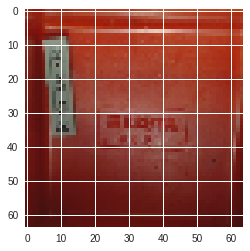

In [161]:
print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))
print ("train_y's shape: " + str(train_y.shape))
print ("test_y's shape: " + str(test_y.shape))

index = 9
plt.imshow(train_x[index])
print(train_y[index])

In [169]:
model.fit(train_x, train_y, epochs = 40, batch_size = 32)

Epoch 1/40
420/420 [==============================] - 3s 7ms/step - loss: 0.8689 - acc: 0.8667
Epoch 2/40
420/420 [==============================] - 3s 6ms/step - loss: 0.3253 - acc: 0.9429
Epoch 3/40
420/420 [==============================] - 2s 6ms/step - loss: 0.1348 - acc: 0.9762
Epoch 4/40
420/420 [==============================] - 2s 6ms/step - loss: 0.0565 - acc: 0.9881
Epoch 5/40
420/420 [==============================] - 2s 6ms/step - loss: 0.2045 - acc: 0.9786
Epoch 6/40
420/420 [==============================] - 2s 6ms/step - loss: 1.6621 - acc: 0.8381
Epoch 7/40
420/420 [==============================] - 2s 6ms/step - loss: 0.3346 - acc: 0.9667
Epoch 8/40
420/420 [==============================] - 2s 6ms/step - loss: 0.1382 - acc: 0.9810
Epoch 9/40
420/420 [==============================] - 2s 6ms/step - loss: 0.1440 - acc: 0.9786
Epoch 10/40
420/420 [==============================] - 2s 6ms/step - loss: 0.7422 - acc: 0.9262
Epoch 11/40
420/420 [============================

In [170]:
preds = model.evaluate(train_x, train_y)
print ("Loss = " + str(preds[0]))
print ("Train Accuracy = " + str(preds[1]))

420/420 [==============================] - 1s 1ms/step
Loss = 6.537182817004976
Train Accuracy = 0.3952380952380952


In [171]:
preds = model.evaluate(test_x, test_y)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

210/210 [==============================] - 0s 1ms/step
Loss = 5.620049594697498
Test Accuracy = 0.5047619047619047


Input image shape: (64, 64, 3)
Input image shape: (1, 64, 64, 3)
[[3.3285217e-14 9.9997306e-01 1.4438055e-08 1.5960732e-07 2.9708074e-09
  2.6867156e-05]]


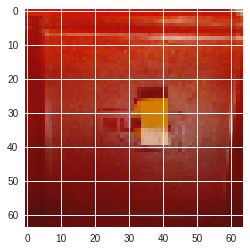

In [0]:
index = 20
classname = 'L05'
plt.imshow(full_dataset[classname][index])
x = full_dataset[classname][index] / 255.
print('Input image shape:', x.shape)
x = np.array([x])
print('Input image shape:', x.shape)

print(model.predict(x))

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 70, 70, 3)    0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

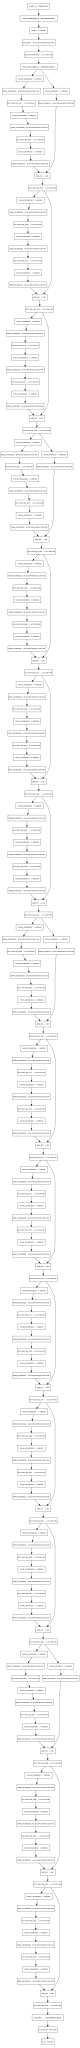

In [0]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))